In [3]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
import os

from util.train_model import ModelTrainer
from util.function import load_train_data,load_test_data,set_seed,gru_dataloader

from model.gru_base import GRUModel

In [4]:
set_seed(0)

Set random seed as 0 for pytorch


# 1.数据加载

## 1.1参数设置

In [3]:
train_start_date = '2012-01-01'
train_end_date = '2016-12-31'
test_start_date = '2017-01-01'
test_end_date = '2024-06-30'
seq_len = 40
step = 5

## 1.2数据预处理

In [4]:
raw_data = pd.read_parquet('/home/chenglei/higgs_quant/fin_con_ML_factor/data/factors/df_factor_20d_return_120101_240831.par')
raw_data.reset_index(inplace=True)
raw_data = raw_data[(raw_data.datetime >= train_start_date) & (raw_data.datetime <= test_end_date)]
raw_data.reset_index(inplace=True,drop=True)
raw_data['return'] = raw_data.groupby('datetime')['return'].apply(lambda x: (x-x.mean())/x.std() if x.std() != 0 else (x-x.mean()))

In [5]:
# 含有 nan 超过 2/3 的行进行剔除，再剔除 y 缺失的行，剩下的特征 nan 值用0值填充
raw_data = raw_data.dropna(thresh=30*2/3,axis = 0)
raw_data = raw_data.dropna(subset=['return'])
raw_data = raw_data.fillna(0)

In [6]:
raw_data

,datetime,stock_code,con_np_yoy_rank_0_neg,con_npgrate_13w_n1_neg,con_peg_0_neg,con_na_0_neg,con_eps_0_neg,con_pe_n1_neg,con_np_0_neg,con_or_yoy_rank_0_neg,...,qfa_deductedprofittoprofit_day,currentdebttodebt_day_no_neu_ind,roic_day,qfa_ocftosales_day,con_pb_n1_20d_pctchange_neg,con_peg_n1_40d_pctchange_div_degree_40d_mean,con_peg_rank_n1_40d_quantile_neg,con_eps_rank_n1_40d_quantile_neg,con_pb_roe_rank_0_60d_quantile_diff,return
0,2012-01-04,000001.SZ,-1.596669,0.051041,0.219036,0.171563,-2.017405,0.469378,0.211076,-1.579931,...,0.000000,0.000000,0.000000,0.017521,-0.863446,-0.254357,0.490604,0.144228,0.386844,0.449654
1,2012-01-04,000002.SZ,-0.372734,-0.049687,0.178856,-8.439709,-1.406188,-0.032110,-8.637513,-0.935532,...,0.000000,0.181095,-0.387832,0.043341,-1.291807,-0.162367,-1.466329,0.482868,-2.167505,-0.348110
2,2012-01-04,000004.SZ,1.208983,1.397304,-10.586397,0.705467,1.166688,-2.834055,0.738565,1.611798,...,0.000000,0.784411,-0.624007,0.079640,0.814592,-0.081248,-0.103655,-0.024616,-0.359889,0.159856
3,2012-01-04,000005.SZ,1.262926,-0.045737,0.166415,0.431885,0.973001,-0.255797,0.413711,1.321765,...,0.000000,0.855715,0.000000,0.126558,-1.178618,-0.162367,-0.832495,0.535393,-1.339208,-0.704925
4,2012-01-04,000006.SZ,-0.075310,-0.073843,0.175828,0.030088,-0.523711,-0.027530,-0.076780,0.086311,...,0.000000,0.313045,0.660729,0.123769,0.044352,-0.162367,0.994439,1.060643,1.711350,0.558699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16721240,2024-06-28,688799.SH,-0.899123,-0.032298,0.227463,0.377478,-1.531321,0.047206,0.161684,-0.919158,...,-0.034506,-0.014273,0.170784,0.046456,-0.377752,-0.056499,-0.889311,-0.300238,1.570332,-0.696330
16721241,2024-06-28,688800.SH,-1.064492,0.053578,0.218436,0.224781,-0.694384,-0.023664,0.109610,-1.139605,...,0.051452,0.077167,0.459559,-0.220112,0.409754,-0.049084,1.089011,-1.676751,1.021840,-0.793533
16721242,2024-06-28,688819.SH,-0.157390,-0.063696,0.293286,-0.652194,-1.233860,0.084775,-0.629888,-0.164431,...,-0.525032,0.381980,0.672106,0.396910,0.014206,-0.173908,-0.146088,-0.845584,0.165994,-0.428161
16721243,2024-06-28,688981.SH,0.132944,-0.049070,0.029073,-9.521651,0.085813,-0.056508,-2.691779,0.445274,...,0.102284,-1.667573,-0.264271,0.579037,-0.461531,-0.048860,1.170419,-1.189996,-0.688854,1.040659


## 1.3格式化数据

In [7]:
x1_train, x1_valid, X_test, y_train, y_valid, y_test, train_date, test_date,sample_stock = gru_dataloader(df = raw_data,
                                                                                             train_start_date = train_start_date,
                                                                                             train_end_date = train_end_date,
                                                                                             test_start_date = test_start_date,
                                                                                             test_end_date = test_end_date,
                                                                                             seq_len = seq_len,
                                                                                             step = step)


100%|██████████| 30/30 [01:29<00:00,  2.97s/it]


In [8]:
print(x1_train.shape,x1_valid.shape,y_train.shape,y_valid.shape)
print(X_test.shape,y_test.shape,test_date.shape)

(544444, 40, 30) (60494, 40, 30) (544444, 1) (60494, 1)
(5253, 1857, 30) (5253, 1857) (1818,)


In [10]:
X_test.dtype

dtype('float64')

In [9]:
class Newdataset(Dataset):
    def __init__(self, data1, label) -> None:
        super().__init__()
        self.data1 = data1.astype(np.float32)
        self.label = label.astype(np.float32)

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, index):
        return self.data1[index], self.label[index]
        
BATCH_SIZE = 5000
train_ds = Newdataset(x1_train, y_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)

valid_ds = Newdataset(x1_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

# 2.模型

## 2.1模型设置

In [10]:
try_label = 'gru_10_07_factor30_v1_y_normal'

In [11]:
model1 = GRUModel()
# model2 = GRUPatchModel()

optimizer1 = optim.Adam(model1.parameters(), lr=0.005)
# optimizer2 = optim.Adam(model2.parameters(), lr=0.005)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modeltrainer1 = ModelTrainer(model1, optimizer1, device, name = try_label)
# modeltrainer2 = ModelTrainer(model2, optimizer2, device, 'gru_patch')

if not os.path.exists(f'data/saved_model'):
    os.makedirs(f'data/saved_model')
if not os.path.exists(f'data/saved_loss'):
    os.makedirs(f'data/saved_loss')

## 2.2 训练

current device: cuda:0
begin time: Mon Oct  7 11:31:26 2024
GRUModel(
  (gru): GRU(30, 60, batch_first=True)
  (head): PredictionHead(
    (dropout): Dropout(p=0.0, inplace=False)
    (hidden): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=60, out_features=1, bias=True)
  )
)
Set random seed as 0 for pytorch


epoch:13 test IC:0.0849 : 100%|██████████| 13/13 [00:00<00:00, 32.14it/s]


([0.07745096642190778,
  0.10471546772115548,
  0.11255193040748938,
  0.11772142455981481,
  0.12314332117232571,
  0.12870444920460838,
  0.13519191813287795,
  0.14206582502517506,
  0.14964822001678874,
  0.15455956088054343,
  0.16104986177278904,
  0.16739782132635558,
  0.16964346988162948,
  0.17862558252084146],
 [0.07542370761243197,
  0.08703133549827796,
  0.09345697410977803,
  0.0945359137482368,
  0.0971523981827956,
  0.09575593385558862,
  0.09837335204848877,
  0.09801546512888028,
  0.09899571681251892,
  0.09153792885347055,
  0.09326580983514969,
  0.09163836246499649,
  0.08898236706423071,
  0.08486669607317218])

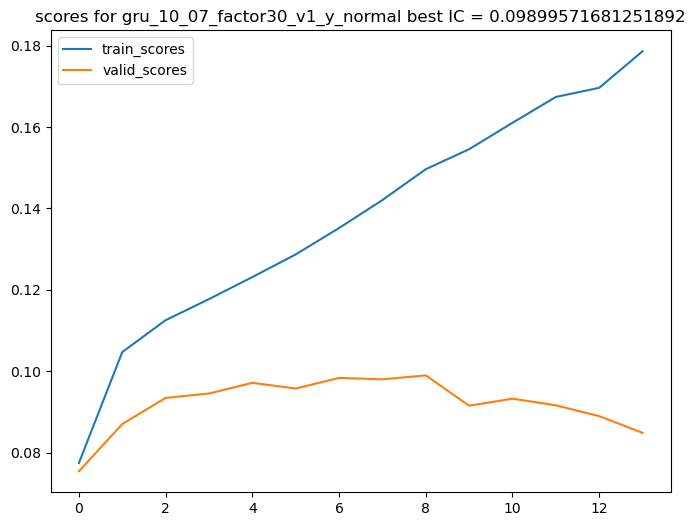

In [12]:
modeltrainer1.fit(train_dl, valid_dl, 'data')
# modeltrainer2.fit(train_dl, test_dl, 'data')

# 3.预测

use the model in test set and get the factor output

## 3.1加载存储模型

In [13]:
# load model
model1 = torch.load(f'data/saved_model/{try_label}.pt')
# model2 = torch.load('data/saved_model/gru_patch.pt')

optimizer1 = optim.Adam(model1.parameters(), lr=0.005)
# optimizer2 = optim.Adam(model2.parameters(), lr=0.005)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modeltrainer1 = ModelTrainer(model1, optimizer1, device,name=try_label)
# modeltrainer2 = ModelTrainer(model2, optimizer2, device, 'gru_patch')

## 3.2定义预测函数

In [14]:
def predict_test_set(X_test, y_test, modeltrainer, test_date, sample_stock):
    """
    该函数用于对测试集进行预测，并返回每个股票在每个测试日期的预测值。

    参数:
    - X_test: np.array, 测试集特征矩阵，维度为 (num_samples, time_steps, num_features)。
    - y_test: np.array, 测试集标签矩阵，维度为 (num_samples, time_steps)。
    - modeltrainer: ModelTrainer 对象，训练好的模型，用于预测。
    - test_date: list, 测试日期列表。
    - sample_stock: list, 样本股票代码。

    返回:
    - fac_1: pd.DataFrame, 每个股票在每个日期的预测值，行是股票，列是日期。
    """

    # 初始化一个 DataFrame，用于存储预测的因子数据（股票的预测值）
    # 大小为 (测试样本数量, 测试日期长度 - 10)
    fac_1 = pd.DataFrame(np.nan * np.zeros((X_test.shape[0], len(test_date))))

    i_panel = 0  # 用于跟踪列的索引（即时间步的索引）
    
    # 遍历测试日期，使用滚动窗口的方式进行预测
    for i in tqdm(range(len(test_date))):
        # 使用 i 到 i+seq_len 作为时间序列窗口提取特征和标签数据
        x1_test, y1_test, nonan_index = load_test_data(X_test[:, i:i+seq_len, :], y_test[:, i:i+seq_len],seq_len=seq_len)

        # 创建测试数据集并加载数据
        test_ds = Newdataset(x1_test, y1_test)  # 创建自定义的数据集
        test_dl = DataLoader(test_ds, batch_size=len(x1_test))  # 创建数据加载器

        # 使用模型进行预测
        y_pred = modeltrainer.predict(test_dl)
        
        # 将预测结果存入 fac_1 中，nonan_index 表示有效样本的索引
        fac_1.iloc[nonan_index, i_panel] = y_pred[:, -1]  # 将预测值的最后一个时间步的结果填入

        i_panel += 1  # 更新列的索引

    # 为 fac_1 的列设置日期标签
    fac_1.columns = test_date[:i_panel]
    
    # 为 fac_1 的行设置股票索引
    fac_1.index = sample_stock

    fac_1.rename_axis(index = 'stock_code',columns = 'datetime',inplace = True)

    fac_1 = fac_1.T

    return fac_1


In [15]:
df_gru_pred_19_23 = predict_test_set(X_test, y_test, modeltrainer1, test_date, sample_stock)
# fac2 = predict_valid_set(X_valid, y_valid, modeltrainer2, valid_date, sample_stock)

100%|██████████| 1818/1818 [02:06<00:00, 14.38it/s]


In [17]:
df_gru_pred_19_23

stock_code,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,688787.SH,688788.SH,688789.SH,688793.SH,688798.SH,688799.SH,688800.SH,688819.SH,688981.SH,689009.SH
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03,4.157673,-0.846832,4.082482,4.174160,-2.763734,3.952549,-2.406728,-1.166307,1.223338,-0.091541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,3.779206,-0.897830,4.232911,3.577367,-2.931113,3.936276,-1.485151,-0.963332,1.162929,-0.943247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,2.986939,-0.961682,4.249853,2.391743,-2.553462,4.209125,-1.351700,-1.417800,1.886813,-0.979051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,2.598134,-0.976320,4.290014,2.941530,-1.698524,4.503687,0.413461,-2.404443,1.405943,-0.801174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,2.059651,-1.580043,4.228618,2.092728,-1.914002,5.255098,-1.015856,-2.211886,0.954536,-2.010727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,5.540699,-2.449641,6.020283,NaN,-0.424626,-1.827869,0.502963,0.589354,-4.359811,-2.485233,...,0.091783,4.647991,-8.786050,-0.275691,-1.417449,-6.084778,1.943695,-1.210041,-4.850011,-11.542457
2024-06-25,4.856597,-2.990992,5.638294,NaN,-1.171937,-1.572802,0.481384,-0.593883,-3.328729,-2.501252,...,-0.095561,5.364792,-9.851790,-0.576422,-0.843730,-4.947876,2.664265,-1.497128,-4.997519,-10.474298
2024-06-26,7.323437,-2.934861,5.296206,NaN,-1.375447,-1.393937,0.529277,-1.866170,-3.814507,-2.111163,...,-0.031522,5.408982,-7.616821,-0.490082,-2.922187,-4.706154,2.926567,-1.780027,-5.108343,-10.371997


# 4.回测

In [18]:
import pandas as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/home/chenglei/higgs_quant')

from AlphaSim.AlphaSim_hf import AlphaBacktestHF
OUTPUT_BASEDIR =  "/home/chenglei/higgs_quant/back_test_results/"

class BaseConfig():
    alpha_name = 'default'
    money = 20000000
    output_basedir = OUTPUT_BASEDIR
    # const_dir =  "/mnt/weka/home/gubingchuan/data_gubc/home/gubingchuan/const"
    const_dir = "/mnt/weka/home/chenglei/higgs_quant/const"
    init_y = False
    # ==================== buy_price 和 sell_price============================
    # 可选close, twap, twap_f2hh, twap_f4hh, twap_56hh, twap_34hh, twap_l4hh
    buy_price = "twap"
    sell_price = "twap"
    period = 20 #调仓周期
    # =====================基准===============================================
    # 可选"HS300", "ZZ500", "Ashare", null,
    benchmark = "Ashare" # 注意，这里的Ashare 指股票池内股票简单平均
    # =====================是否考虑交易限制====================================
    # 可选'lock', 'remove', 'free', 分别代表：
    # lock：锁住涨跌停的仓位
    # remove：涨跌停的股票置为0
    # free：不考虑涨跌停限制
    trade_constrain = 'free'
    # =====================时间===============================================
    start_date = "2014-01-01"
    end_date = "2023-12-31"
    # ======================对alpha的处理=====================================
    # 强制市场中性
    is_market_neutral = True
    # 市值分层中性 # 暂时没用
    is_cap_neutral = False # 暂时没用
    # 行业中性,目前行业数据更新到 202400630
    is_industry_neutral = False
    # 选取部分行业回测，空列表[]默认为所有行业，行业标准参考申万 1 级
    is_part_industry = []
    # ======================是否做分组测试=====================================
    is_group_test = False

[2370824:MainThread](2024-10-07 11:34:41,499) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:55] - Initialization
[2370824:MainThread](2024-10-07 11:34:41,564) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:98] - Use old y, start prepare_y


return_future is aquired
RankIC is calculated


[2370824:MainThread](2024-10-07 11:35:17,053) INFO - AlphaSim.AlphaBacktestHF - [AlphaSim_hf.py:394] - pic has been saved in /home/chenglei/higgs_quant/back_test_results/group_test_results/df_gru_pred_19_23.png


df_gru_pred_19_23


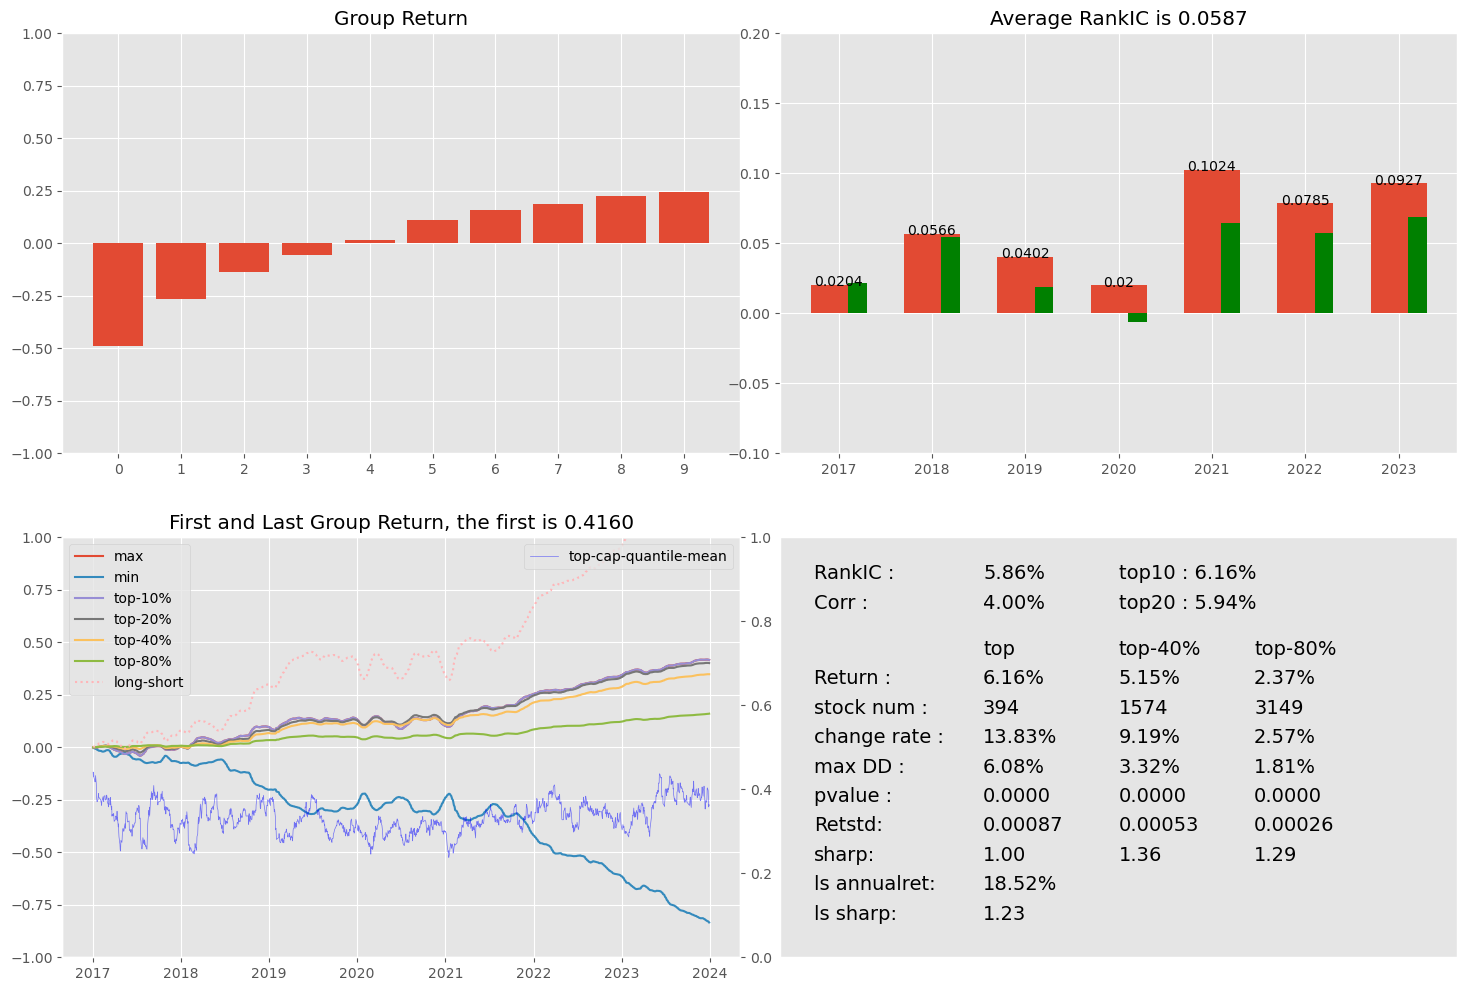

strategy_test func time_cost -> 35.94214606285095


In [19]:
Backtest = AlphaBacktestHF(BaseConfig)
result = Backtest.strategy_test(
    df_gru_pred_19_23,
    ngrp=10,
    name=f'df_gru_pred_19_23')
